<a href="https://colab.research.google.com/github/rahiakela/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/blob/11-training-deep-neural-networks/faster_optimizers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Faster Optimizers

Training a very large deep neural network can be painfully slow. So far we have seen four ways to speed up training (and reach a better solution): 

* applying a good initialization strategy for the connection weights, 
* using a good activation function, 
* using Batch Normalization, 
* and reusing parts of a pretrained network

Another huge speed boost comes from using a faster optimizer than the regular Gradient Descent optimizer. Lets analyze these most popular ones: 
* Momentum optimization, 
* Nesterov Accelerated Gradient, 
* AdaGrad, 
* RMSProp, 
* and finally Adam and Nadam optimization.

## Setup

In [1]:
import sys
assert sys.version_info >= (3, 5)  # Python ≥3.5 is required

import sklearn 
assert sklearn.__version__ >= "0.20"  # Scikit-Learn ≥0.20 is required

# %tensorflow_version only exists in Colab.
try:
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= '2.0'

# Common imports
import numpy as np
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
import tensorflow.keras.backend as keras_backend

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

TensorFlow 2.x selected.


In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

X_train_full = X_train_full / 255.
X_test = X_test / 255.

X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

4423680/4422102 [==============================] - 0s 0us/step


## Momentum optimization

Recall that Gradient Descent simply updates the weights θ by directly subtracting the gradient of the cost function J(θ) with regards to the weights (∇θJ(θ)) multiplied by the learning rate η.

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/gradient.PNG?raw=1' width='800'/>

It does not care about what the earlier gradients were. If the local gradient is tiny, it goes very slowly.

Momentum optimization cares a great deal about what previous gradients were: at
each iteration, it subtracts the local gradient from the momentum vector m (multiplied by the learning rate η), and it updates the weights by simply adding this momentum vector.

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/momentum-algo.PNG?raw=1' width='800'/>

In other words, the gradient is used for acceleration,
not for speed. To simulate some sort of friction mechanism and prevent the
momentum from growing too large, the algorithm introduces a new hyperparameter
β, simply called the momentum, which must be set between 0 (high friction) and 1
(no friction). A typical momentum value is 0.9.

Implementing Momentum optimization in Keras is a no-brainer: just use the SGD
optimizer and set its momentum hyperparameter, then lie back and profit!

```python
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)
```

The one drawback of Momentum optimization is that it adds yet another hyperparameter to tune. However, the momentum value of 0.9 usually works well in practice and almost always goes faster than regular Gradient Descent.

## Nesterov Accelerated Gradient

One small variant to Momentum optimization is almost always faster than vanilla Momentum optimization. The idea of Nesterov Momentum optimization, or Nesterov Accelerated Gradient (NAG), is to measure the gradient of the cost function not at the local position but slightly ahead in the direction of the momentum.

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/nesterov-algo.PNG?raw=1' width='800'/>

NAG will almost always speed up training compared to regular Momentum optimization. To use it, simply set nesterov=True when creating the SGD optimizer.

```python
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)
```
This small tweak works because in general the momentum vector will be pointing in the right direction (i.e., toward the optimum), so it will be slightly more accurate to use the gradient measured a bit farther in that direction rather than using the gradient at the original position.

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/nesterov-momentum-optimization.PNG?raw=1' width='800'/>

## AdaGrad

The AdaGrad algorithm achieves this by scaling down the gradient vector along the steepest dimensions.

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/adagrad-algo.PNG?raw=1' width='800'/>

* The first step accumulates the square of the gradients into the vector s (recall that the ⊗ symbol represents the element-wise multiplication).If the cost function is steep along the ith dimension, then si will get larger and larger at each iteration.
* The second step is almost identical to Gradient Descent, but with one big difference: the gradient vector is scaled down by a factor of square root of s + epsilon(the ⊘ symbol represents the element-wise division, and ϵ is a smoothing term to avoid division by zero, typically set to 10–10).

This algorithm decays the learning rate, but it does so faster for steep dimensions than for dimensions with gentler slopes. This is called an adaptive learning rate. It helps point the resulting updates more directly toward the global optimum.One additional benefit is that it requires much less tuning of the learning rate hyperparameter η.

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/adagrad-versus-gradient-descent.PNG?raw=1' width='800'/>

AdaGrad often performs well for simple quadratic problems, but unfortunately it
often stops too early when training neural networks. The learning rate gets scaled
down so much that the algorithm ends up stopping entirely before reaching the
global optimum. So even though Keras has an Adagrad optimizer, you should not use
it to train deep neural networks (it may be efficient for simpler tasks such as Linear
Regression, though). However, understanding Adagrad is helpful to grasp the other
adaptive learning rate optimizers.

```python
optimizer = keras.optimizers.Adagrad(lr=0.001)
```

## RMSProp

Although AdaGrad slows down a bit too fast and ends up never converging to the
global optimum, the RMSProp algorithm15 fixes this by accumulating only the gradients from the most recent iterations (as opposed to all the gradients since the beginning of training). It does so by using exponential decay in the first step.

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/rmsprop-algo.PNG?raw=1' width='800'/>

The decay rate β is typically set to 0.9. Yes, it is once again a new hyperparameter, but
this default value often works well, so you may not need to tune it at all.

```python
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)
```

Except on very simple problems, this optimizer almost always performs much better than AdaGrad. In fact, it was the preferred optimization algorithm of many researchers until Adam optimization came around.

## Adam and Nadam Optimization

Adam, which stands for adaptive moment estimation, combines the ideas of Momentum optimization and RMSProp: just like Momentum optimization it keeps track of an exponentially decaying average of past gradients, and just like RMSProp it keeps track of an exponentially decaying average of past squared gradients.

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/adam-algo.PNG?raw=1' width='800'/>

If you just look at steps 1, 2, and 5, you will notice Adam’s close similarity to both Momentum optimization and RMSProp. The only difference is that step 1 computes an exponentially decaying average rather than an exponentially decaying sum, but these are actually equivalent except for a constant factor (the decaying average is just 1 – β1 times the decaying sum).

The momentum decay hyperparameter β1 is typically initialized to 0.9, while the scaling decay hyperparameter β2 is often initialized to 0.999. As earlier, the smoothing term ϵ is usually initialized to a tiny number such as 10–7.

```python
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
```

Since Adam is an adaptive learning rate algorithm (like AdaGrad and RMSProp), it
requires less tuning of the learning rate hyperparameter η. You can often use the default value η = 0.001, making Adam even easier to use than Gradient Descent.

All the optimization techniques discussed so far only rely on the first-order partial derivatives (Jacobians). The optimization literature contains amazing algorithms based on the second-order partial derivatives (the Hessians, which are the partial derivatives of the Jacobians). Unfortunately, these algorithms are very hard to apply to deep neural networks because there are n2 Hessians per output (where n is the number of parameters), as opposed to just n Jacobians per output. 

Since DNNs typically have tens of thousands of parameters, the second-order optimization algorithms often don’t even fit in memory, and even when they do, computing the Hessians is just too slow.





## Learning Rate Scheduling

Finding a good learning rate can be tricky. If you set it way too high, training may actually diverge.If you set it too low, training will
eventually converge to the optimum, but it will take a very long time. If you set it slightly too high, it will make progress very quickly at first, but it will end up dancing around the optimum, never really settling down. If you have a limited computing budget, you may have to interrupt training before it has converged properly, yielding a suboptimal solution.

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/learning-curves.PNG?raw=1' width='800'/>

However, you can do better than a constant learning rate: if you start with a high learning rate and then reduce it once it stops making fast progress, you can reach a good solution faster than with the optimal constant learning rate. There are many different strategies to reduce the learning rate during training. These strategies are called learning schedules, the most common
of which are:

* Power scheduling
* Exponential scheduling
* Piecewise constant scheduling
* Performance scheduling



### Power Scheduling

Set the learning rate to a function of the iteration number t: η(t) = η0 / (1 + t/k)c. The initial learning rate η0, the power c (typically set to 1) and the steps s are hyperparameters. The learning rate drops at each step, and after s steps it is down to η0 / 2. After s more steps, it is down to η0 / 3. Then down to η0 / 4, then η0 / 5, and so on. As you can see, this schedule first drops quickly, then more and more slowly. Of course, this requires tuning η0, s (and possibly c).

In [0]:
# Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

model = Sequential([
    Flatten(input_shape=[28, 28]),
    Dense(300, activation='selu', kernel_initializer='lecun_normal'),
    Dense(100, activation='selu', kernel_initializer='lecun_normal'), 
    Dense(10, activation='softmax'),             
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=SGD(learning_rate=0.01, decay=1e-4), metrics=['accuracy'])

In [16]:
history = model.fit(X_train_scaled, y_train, epochs=25, validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 6s 108us/sample - loss: 0.2378 - accuracy: 0.9175 - val_loss: 0.3288 - val_accuracy: 0.8866
Epoch 2/25
55000/55000 [==============================] - 6s 111us/sample - loss: 0.2377 - accuracy: 0.9174 - val_loss: 0.3288 - val_accuracy: 0.8870
Epoch 3/25
55000/55000 [==============================] - 6s 108us/sample - loss: 0.2376 - accuracy: 0.9174 - val_loss: 0.3287 - val_accuracy: 0.8870
Epoch 4/25
55000/55000 [==============================] - 6s 110us/sample - loss: 0.2375 - accuracy: 0.9175 - val_loss: 0.3287 - val_accuracy: 0.8868
Epoch 5/25
55000/55000 [==============================] - 6s 109us/sample - loss: 0.2374 - accuracy: 0.9175 - val_loss: 0.3288 - val_accuracy: 0.8876
Epoch 6/25
55000/55000 [==============================] - 6s 110us/sample - loss: 0.2373 - accuracy: 0.9175 - val_loss: 0.3287 - val_accuracy: 0.8870
Epoch 7/25
55000/55000 [===========================

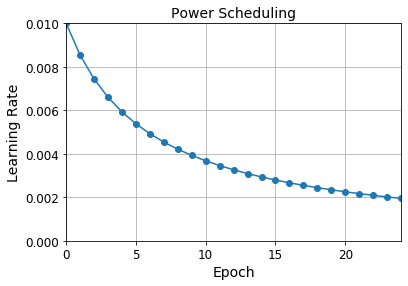

In [18]:
learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
epochs = np.arange(25)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, 25 - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Scheduling

Set the learning rate to: η(t) = η0 0.1t/s. The learning rate will gradually drop by a factor of 10 every s steps. While power scheduling reduces the learning rate more and more slowly, exponential scheduling keeps slashing it by a factor of 10 every s steps.

In [0]:
def exponential_decay_fn(epoch):
  return 0.01 * 0.1 ** (epoch / 20)

In [0]:
def exponential_decay(lr0, s):

  def exponential_decay_fn(epoch):
    return lr0 * 0.1 ** (epoch / s)
  
  return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20) 

In [0]:
model = Sequential([
    Flatten(input_shape=[28, 28]),
    Dense(300, activation='selu', kernel_initializer='lecun_normal'),
    Dense(100, activation='selu', kernel_initializer='lecun_normal'), 
    Dense(10, activation='softmax'),             
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=SGD(learning_rate=0.01, decay=1e-4), metrics=['accuracy'])

In [15]:
n_epochs = 25
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

history = model.fit(X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid), callbacks=[lr_scheduler])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 7s 122us/sample - loss: 0.2664 - accuracy: 0.9057 - val_loss: 0.3348 - val_accuracy: 0.8808
Epoch 2/25
55000/55000 [==============================] - 6s 114us/sample - loss: 0.2624 - accuracy: 0.9073 - val_loss: 0.3365 - val_accuracy: 0.8836
Epoch 3/25
55000/55000 [==============================] - 6s 112us/sample - loss: 0.2589 - accuracy: 0.9087 - val_loss: 0.3337 - val_accuracy: 0.8810
Epoch 4/25
55000/55000 [==============================] - 6s 112us/sample - loss: 0.2559 - accuracy: 0.9098 - val_loss: 0.3329 - val_accuracy: 0.8848
Epoch 5/25
55000/55000 [==============================] - 6s 112us/sample - loss: 0.2535 - accuracy: 0.9109 - val_loss: 0.3316 - val_accuracy: 0.8826
Epoch 6/25
55000/55000 [==============================] - 6s 112us/sample - loss: 0.2514 - accuracy: 0.9121 - val_loss: 0.3304 - val_accuracy: 0.8876
Epoch 7/25
55000/55000 [===========================

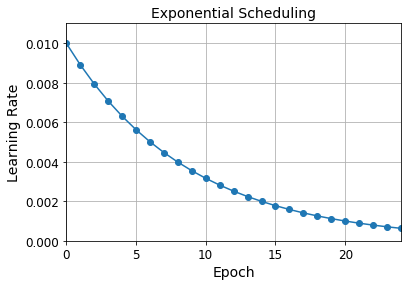

In [14]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [0]:
def exponential_decay_fn(epoch, lr):
  return lr * 0.1 ** (1 / 20)

If you want to update the learning rate at each iteration rather than at each epoch, you must write your own callback class:

In [19]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):

  def __init__(self, s=40000):
    super().__init__()
    self.s = s

  def on_batch_begin(self, batch, logs=None):
    # Note: the `batch` argument is reset at each epoch
    lr = K.get_value(self.model.optimizer.lr)
    K.set_value(self.model.optimizer.lr, lr * 0.1 ** (1 / s))

  def on_epoch_end(self, epoch, logs=None):
    logs = logs or {}
    logs['lr'] = K.get_value(self.model.optimizer.lr)


model = Sequential([
    Flatten(input_shape=[28, 28]),
    Dense(300, activation='selu', kernel_initializer='lecun_normal'),
    Dense(100, activation='selu', kernel_initializer='lecun_normal'), 
    Dense(10, activation='softmax'),             
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=SGD(learning_rate=0.01, decay=1e-4), metrics=['accuracy'])

lr0 = 0.01
optimizer = keras.optimizers.Nadam(lr=lr0)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
n_epochs = 25

s = 20 * len(X_train) // 32    # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid), callbacks=[exp_decay])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 13s 233us/sample - loss: 0.7858 - accuracy: 0.7707 - val_loss: 0.6059 - val_accuracy: 0.8114
Epoch 2/25
55000/55000 [==============================] - 12s 212us/sample - loss: 0.6271 - accuracy: 0.8071 - val_loss: 0.5873 - val_accuracy: 0.8312
Epoch 3/25
55000/55000 [==============================] - 12s 217us/sample - loss: 0.5694 - accuracy: 0.8241 - val_loss: 0.5010 - val_accuracy: 0.8490
Epoch 4/25
55000/55000 [==============================] - 12s 213us/sample - loss: 0.4928 - accuracy: 0.8444 - val_loss: 0.5444 - val_accuracy: 0.8334
Epoch 5/25
55000/55000 [==============================] - 12s 222us/sample - loss: 0.4681 - accuracy: 0.8516 - val_loss: 0.6302 - val_accuracy: 0.8178
Epoch 6/25
55000/55000 [==============================] - 12s 221us/sample - loss: 0.4176 - accuracy: 0.8661 - val_loss: 0.4971 - val_accuracy: 0.8568
Epoch 7/25
55000/55000 [=====================

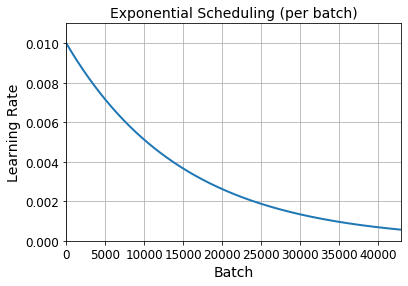

In [20]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1 ** (steps / s)

plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### Piecewise constant scheduling

Use a constant learning rate for a number of epochs (e.g., η0 = 0.1 for 5 epochs), then a smaller learning rate for another number of epochs (e.g., η1 = 0.001 for 50 epochs), and so on. Although this solution can work very well, it requires fiddling around to figure out the right sequence of learning rates, and how long to use each of them.